# PREDICTING IMMUNIZATION DROP-OUTS

**Context:** Although vaccination rates have increased globally over the last twenty years — largely
due to efforts to ensure vaccines are stocked at convenient points of care even in remote locations
— they have plateaued in the last decade. This is largely attributable to children who drop out of
their vaccination schedule, i.e., do not receive all their required vaccines, despite access. Delayed
vaccination puts many children at risk and often requires costly vaccination campaigns to resolve.

**Problem Statement:** Imagine you are working with an organization that runs health clinics in
Botswana. They want to be able to send health workers to follow-up with children who have not yet
received all 4 doses of OPV and 3 doses of DPT at 4 months of life. They cannot individually follow-
up with all children, so your job is to help them target their intervention by predicting which children
will not become vaccinated by 6 months without intervention. Therefore, you can use all
information; for example, which vaccines the child received, up until 4 months after the child is
born.

## Part 1: Data preparation

In [1]:
#Installing necessary libraries
import pandas as pd #Data analyis library
import numpy as np #Mathematical computation library

import seaborn as sns #Library for visualization
from matplotlib import pyplot as plt #Library for visualization

#Displays output inline
%matplotlib inline 

In [2]:
#Reading patients data
patients_data = pd.read_csv('~/Elvis/macro-eyes/ML_Assignment/Data/patients_db_v2.csv',index_col=[0]) #index_col avoids pandas setting Unnamed: 0 column as the index

patients_data.shape #shape of the dataset (Rows, columns)

(50000, 8)

In [3]:
#reading the first 5 entries of our data
patients_data.head()

pat_id  fac_id         dob gender       long        lat   region  \
0       1    51.0  2019-01-22      f        NaN        NaN   Ghanzi   
1       2    89.0  2019-11-12      f  24.877556 -18.370709    Chobe   
2       3   161.0  2019-11-03      m  25.249672 -20.490189  Central   
3       4   168.0  2019-04-17      f  25.579269 -21.412151  Central   
4       5   183.0  2018-12-08      m  28.487746 -22.571451  Central   

     district  
0      Ghanzi  
1       Chobe  
2      Tutume  
3  Lethlakane  
4        Tuli

In [4]:
patients_data.nunique() #unique values in each column

pat_id      50000
fac_id        345
dob           730
gender          2
long          345
lat           345
region         15
district       24
dtype: int64

In [5]:
patients_data.isnull().sum()  #Checking the sum of null entries in each column

pat_id         0
fac_id      2504
dob            0
gender      1002
long        2536
lat         2536
region      1634
district    1634
dtype: int64

In [6]:
#Reading immunization data
immunization_data = pd.read_csv('~/Elvis/macro-eyes/ML_Assignment/Data/immunization_db_v2.csv',index_col=[0]) #index_col avoids pandas setting Unnamed: 0 column as the index

immunization_data.shape #shape of the dataset (Rows, columns)

(276764, 5)

In [7]:
immunization_data.head() #First 5 entries of the immunization data

pat_id vaccine     im_date  successful reason_unsuccesful
0       1     OPV  2019-01-31        True                NaN
1       2     OPV  2019-11-12        True                NaN
2       3     OPV  2019-11-03        True                NaN
3       4     OPV  2019-06-01        True                NaN
4       5     OPV  2018-12-24        True                NaN

In [8]:
immunization_data.isnull().sum() #Checking the sum of null entries in each column

pat_id                     0
vaccine                    0
im_date                    0
successful                 0
reason_unsuccesful    273865
dtype: int64

In [9]:
immunization_data.nunique() #Number of unique values in each column

pat_id                48843
vaccine                   2
im_date                 730
successful                2
reason_unsuccesful        4
dtype: int64

In [10]:
immunization_data[immunization_data.duplicated(['pat_id'], keep=False)].sort_values(by=['pat_id']) #Show all rows that are duplicates based on the column pat_id

pat_id vaccine     im_date  successful reason_unsuccesful
0            1     OPV  2019-01-31        True                NaN
94558        1     OPV  2019-05-25        True                NaN
177203       1     DTP  2019-04-03        True                NaN
222734       1     DTP  2019-05-25        True                NaN
49155        1     OPV  2019-04-03        True                NaN
...        ...     ...         ...         ...                ...
137244   50000     OPV  2019-09-20        True                NaN
177202   50000     OPV  2019-11-01        True                NaN
265514   50000     DTP  2019-09-20        True                NaN
94557    50000     OPV  2019-08-09        True                NaN
305578   50000     DTP  2019-11-01        True                NaN

[273331 rows x 5 columns]

In [11]:
df=pd.crosstab(immunization_data.pat_id,immunization_data.vaccine) #performing cross-tabulation of pat_id and vaccine columns

In [12]:
df

vaccine  DTP  OPV
pat_id           
1          3    4
2          0    1
3          1    2
4          3    4
5          2    4
...      ...  ...
49996      2    3
49997      3    3
49998      3    4
49999      3    4
50000      3    4

[48843 rows x 2 columns]

In [13]:
df_final = immunization_data.drop('vaccine', axis=1).drop_duplicates('pat_id').join(df, on='pat_id') #we will now drop vaccine column and also drop duplicates on pat_id column

In [14]:
df_final

pat_id     im_date  successful reason_unsuccesful  DTP  OPV
0            1  2019-01-31        True                NaN    3    4
1            2  2019-11-12        True                NaN    0    1
2            3  2019-11-03        True                NaN    1    2
3            4  2019-06-01        True                NaN    3    4
4            5  2018-12-24        True                NaN    2    4
...        ...         ...         ...                ...  ...  ...
216260   42919  2019-12-20        True                NaN    1    0
216287   42948  2019-12-26        True                NaN    1    0
219796   46788  2019-11-19        True                NaN    1    0
221128   48254  2019-12-28        True                NaN    1    0
221232   48363  2019-07-22       False         OutOfStock    1    0

[48843 rows x 6 columns]

In [15]:
df_final.nunique() #Unique values for immunization data after feature engineering

pat_id                48843
im_date                 729
successful                2
reason_unsuccesful        4
DTP                       4
OPV                       5
dtype: int64

In [16]:
conditions = [
    df_final['DTP'].eq(3) & df_final['OPV'].eq(4)
]

choices = [1]

#df_final['full_dose'] = np.select(conditions, choices, default=0)

In [17]:
df_final['full_dose'] = np.select(conditions, choices, default=0)

In [18]:
df_final

pat_id     im_date  successful reason_unsuccesful  DTP  OPV  full_dose
0            1  2019-01-31        True                NaN    3    4          1
1            2  2019-11-12        True                NaN    0    1          0
2            3  2019-11-03        True                NaN    1    2          0
3            4  2019-06-01        True                NaN    3    4          1
4            5  2018-12-24        True                NaN    2    4          0
...        ...         ...         ...                ...  ...  ...        ...
216260   42919  2019-12-20        True                NaN    1    0          0
216287   42948  2019-12-26        True                NaN    1    0          0
219796   46788  2019-11-19        True                NaN    1    0          0
221128   48254  2019-12-28        True                NaN    1    0          0
221232   48363  2019-07-22       False         OutOfStock    1    0          0

[48843 rows x 7 columns]

In [19]:
# Merging the patients and immunization datasets(df_final)
data = pd.merge(patients_data, df_final)

In [20]:
data.columns

Index(['pat_id', 'fac_id', 'dob', 'gender', 'long', 'lat', 'region',
       'district', 'im_date', 'successful', 'reason_unsuccesful', 'DTP', 'OPV',
       'full_dose'],
      dtype='object')

In [21]:
data

pat_id  fac_id         dob gender       long        lat      region  \
0           1    51.0  2019-01-22      f        NaN        NaN      Ghanzi   
1           2    89.0  2019-11-12      f  24.877556 -18.370709       Chobe   
2           3   161.0  2019-11-03      m  25.249672 -20.490189     Central   
3           4   168.0  2019-04-17      f  25.579269 -21.412151     Central   
4           5   183.0  2018-12-08      m  28.487746 -22.571451     Central   
...       ...     ...         ...    ...        ...        ...         ...   
48838   49996   191.0  2019-06-17      f  28.551843 -22.495365     Central   
48839   49997   299.0  2018-09-11      m        NaN        NaN  North-West   
48840   49998   173.0  2018-10-09      f  22.709613 -20.463382  North-West   
48841   49999   333.0  2018-08-26      m  23.356211 -20.074906  North-West   
48842   50000   190.0  2019-06-14      f  28.549859 -22.495466     Central   

             district     im_date  successful reason_unsuccesful  DTP  OPV  \
0              Ghanzi  2019-01-31        True                NaN    3    4   
1               Chobe  2019-11-12        True                NaN    0    1   
2              Tutume  2019-11-03        True                NaN    1    2   
3          Lethlakane  2019-06-01        True                NaN    3    4   
4                Tuli  2018-12-24        True                NaN    2    4   
...               ...         ...         ...                ...  ...  ...   
48838            Tuli  2019-06-17        True                NaN    2    3   
48839  Ngamiland East  2018-09-11        True                NaN    3    3   
48840  Ngamiland West  2018-10-17        True                NaN    3    4   
48841  Ngamiland East  2018-08-26        True                NaN    3    4   
48842            Tuli  2019-06-14        True                NaN    3    4   

       full_dose  
0              1  
1              0  
2              0  
3              1  
4              0  
...          ...  
48838          0  
48839          0  
48840          1  
48841          1  
48842          1  

[48843 rows x 14 columns]

In [22]:
data.describe() #statistical summary of our dataset

pat_id        fac_id          long           lat           DTP  \
count  48843.000000  46395.000000  46372.000000  46372.000000  48843.000000   
mean   25019.539402    173.131825     24.829615    -21.280283      2.374383   
std    14434.053903     99.786259      1.976689      2.272329      0.925394   
min        1.000000      1.000000     20.216349    -26.328640      0.000000   
25%    12523.500000     87.000000     23.356419    -22.575735      2.000000   
50%    25033.000000    173.000000     24.784149    -20.287375      3.000000   
75%    37518.500000    260.000000     25.914824    -19.977738      3.000000   
max    50000.000000    345.000000     28.633995    -17.790980      3.000000   

                OPV     full_dose  
count  48843.000000  48843.000000  
mean       3.292017      0.426919  
std        0.955802      0.494635  
min        0.000000      0.000000  
25%        3.000000      0.000000  
50%        4.000000      0.000000  
75%        4.000000      1.000000  
max        4.000000      1.000000

### Dealing with null values

In [23]:
data.isnull().sum()

pat_id                    0
fac_id                 2448
dob                       0
gender                  976
long                   2471
lat                    2471
region                 1602
district               1602
im_date                   0
successful                0
reason_unsuccesful    48808
DTP                       0
OPV                       0
full_dose                 0
dtype: int64

We can see that some columns in our dataset has null values,it is important that we deal with them since most models don't perform with them

In [24]:
# Getting the value_counts in successful column
data.successful.value_counts()

True     48808
False       35
Name: successful, dtype: int64

We can note that the number null values in reason_unsuccesful column are the patients whose immunization was successful, so we can impute them with 0 to mean that the immunization was successful

In [25]:
data['reason_unsuccesful'] = data['reason_unsuccesful'].fillna(0)

In [26]:
data

pat_id  fac_id         dob gender       long        lat      region  \
0           1    51.0  2019-01-22      f        NaN        NaN      Ghanzi   
1           2    89.0  2019-11-12      f  24.877556 -18.370709       Chobe   
2           3   161.0  2019-11-03      m  25.249672 -20.490189     Central   
3           4   168.0  2019-04-17      f  25.579269 -21.412151     Central   
4           5   183.0  2018-12-08      m  28.487746 -22.571451     Central   
...       ...     ...         ...    ...        ...        ...         ...   
48838   49996   191.0  2019-06-17      f  28.551843 -22.495365     Central   
48839   49997   299.0  2018-09-11      m        NaN        NaN  North-West   
48840   49998   173.0  2018-10-09      f  22.709613 -20.463382  North-West   
48841   49999   333.0  2018-08-26      m  23.356211 -20.074906  North-West   
48842   50000   190.0  2019-06-14      f  28.549859 -22.495466     Central   

             district     im_date  successful reason_unsuccesful  DTP  OPV  \
0              Ghanzi  2019-01-31        True                  0    3    4   
1               Chobe  2019-11-12        True                  0    0    1   
2              Tutume  2019-11-03        True                  0    1    2   
3          Lethlakane  2019-06-01        True                  0    3    4   
4                Tuli  2018-12-24        True                  0    2    4   
...               ...         ...         ...                ...  ...  ...   
48838            Tuli  2019-06-17        True                  0    2    3   
48839  Ngamiland East  2018-09-11        True                  0    3    3   
48840  Ngamiland West  2018-10-17        True                  0    3    4   
48841  Ngamiland East  2018-08-26        True                  0    3    4   
48842            Tuli  2019-06-14        True                  0    3    4   

       full_dose  
0              1  
1              0  
2              0  
3              1  
4              0  
...          ...  
48838          0  
48839          0  
48840          1  
48841          1  
48842          1  

[48843 rows x 14 columns]

In [28]:
data.long.value_counts()

26.443981    175
25.926006    163
28.591912    162
25.903306    160
23.356253    160
            ... 
25.306778    112
21.793393    108
23.356168    105
28.552731    105
25.306726    102
Name: long, Length: 345, dtype: int64

In [29]:
data.lat.value_counts()

-21.869801    175
-24.677843    163
-22.483254    162
-24.658432    160
-20.074948    160
             ... 
-20.189820    112
-18.272357    108
-20.074977    105
-22.495150    105
-20.189938    102
Name: lat, Length: 345, dtype: int64

In [80]:
data.isnull().sum()

pat_id                   0
fac_id                2448
dob                      0
gender                 976
long                  2471
lat                   2471
region                1602
district              1602
im_date                  0
successful               0
reason_unsuccesful       0
DTP                      0
OPV                      0
full_dose                0
dtype: int64

We have other rows that contain null values and I choose to drop them since we won't loose alot of information because they are few compared to our dataset, but if you have dataset which has no a lot of entries, it is advisable to use other methods of dealing with them each imputation either using mean, median or mode.

In [30]:
data.dropna(inplace=True) #dropping the null values

In [31]:
data

pat_id  fac_id         dob gender       long        lat      region  \
1           2    89.0  2019-11-12      f  24.877556 -18.370709       Chobe   
2           3   161.0  2019-11-03      m  25.249672 -20.490189     Central   
3           4   168.0  2019-04-17      f  25.579269 -21.412151     Central   
4           5   183.0  2018-12-08      m  28.487746 -22.571451     Central   
5           6   142.0  2018-09-06      f  26.241089 -20.298571     Central   
...       ...     ...         ...    ...        ...        ...         ...   
48837   49995   221.0  2018-01-26      f  27.470027 -21.435094     Central   
48838   49996   191.0  2019-06-17      f  28.551843 -22.495365     Central   
48840   49998   173.0  2018-10-09      f  22.709613 -20.463382  North-West   
48841   49999   333.0  2018-08-26      m  23.356211 -20.074906  North-West   
48842   50000   190.0  2019-06-14      f  28.549859 -22.495466     Central   

             district     im_date  successful reason_unsuccesful  DTP  OPV  \
1               Chobe  2019-11-12        True                  0    0    1   
2              Tutume  2019-11-03        True                  0    1    2   
3          Lethlakane  2019-06-01        True                  0    3    4   
4                Tuli  2018-12-24        True                  0    2    4   
5              Tutume  2018-09-06        True                  0    3    4   
...               ...         ...         ...                ...  ...  ...   
48837          Serowe  2018-02-26        True                  0    2    4   
48838            Tuli  2019-06-17        True                  0    2    3   
48840  Ngamiland West  2018-10-17        True                  0    3    4   
48841  Ngamiland East  2018-08-26        True                  0    3    4   
48842            Tuli  2019-06-14        True                  0    3    4   

       full_dose  
1              0  
2              0  
3              1  
4              0  
5              1  
...          ...  
48837          0  
48838          0  
48840          1  
48841          1  
48842          1  

[41784 rows x 14 columns]

After dropping the rows with null values we remain with 41,784 entries in our dataset

In [33]:
data.isnull().sum() 

pat_id                0
fac_id                0
dob                   0
gender                0
long                  0
lat                   0
region                0
district              0
im_date               0
successful            0
reason_unsuccesful    0
DTP                   0
OPV                   0
full_dose             0
dtype: int64

In [34]:
data

pat_id  fac_id         dob gender       long        lat      region  \
1           2    89.0  2019-11-12      f  24.877556 -18.370709       Chobe   
2           3   161.0  2019-11-03      m  25.249672 -20.490189     Central   
3           4   168.0  2019-04-17      f  25.579269 -21.412151     Central   
4           5   183.0  2018-12-08      m  28.487746 -22.571451     Central   
5           6   142.0  2018-09-06      f  26.241089 -20.298571     Central   
...       ...     ...         ...    ...        ...        ...         ...   
48837   49995   221.0  2018-01-26      f  27.470027 -21.435094     Central   
48838   49996   191.0  2019-06-17      f  28.551843 -22.495365     Central   
48840   49998   173.0  2018-10-09      f  22.709613 -20.463382  North-West   
48841   49999   333.0  2018-08-26      m  23.356211 -20.074906  North-West   
48842   50000   190.0  2019-06-14      f  28.549859 -22.495466     Central   

             district     im_date  successful reason_unsuccesful  DTP  OPV  \
1               Chobe  2019-11-12        True                  0    0    1   
2              Tutume  2019-11-03        True                  0    1    2   
3          Lethlakane  2019-06-01        True                  0    3    4   
4                Tuli  2018-12-24        True                  0    2    4   
5              Tutume  2018-09-06        True                  0    3    4   
...               ...         ...         ...                ...  ...  ...   
48837          Serowe  2018-02-26        True                  0    2    4   
48838            Tuli  2019-06-17        True                  0    2    3   
48840  Ngamiland West  2018-10-17        True                  0    3    4   
48841  Ngamiland East  2018-08-26        True                  0    3    4   
48842            Tuli  2019-06-14        True                  0    3    4   

       full_dose  
1              0  
2              0  
3              1  
4              0  
5              1  
...          ...  
48837          0  
48838          0  
48840          1  
48841          1  
48842          1  

[41784 rows x 14 columns]

In [36]:
data.to_csv("/home/david/Elvis/macro-eyes/ML_Assignment/Data/data_clean1.csv")

Now our dataset is free of Null values

## Part 2: Exploratory data analysis

In [85]:
pd.DataFrame(data[['region','full_dose']].value_counts())

0
region        full_dose      
North-West    0          8003
              1          6326
Central       0          5403
              1          3935
Chobe         0          2612
Gaborone      0          2448
              1          1907
Chobe         1          1651
Kgalagadi     0          1373
Ghanzi        0          1085
Kgalagadi     1           975
South-East    0           852
Ghanzi        1           789
Francistown   0           773
              1           640
South-East    1           562
Selibe Phikwe 0           309
North-East    0           291
Kweneng       0           290
Selibe Phikwe 1           275
Lobatse       0           227
North-East    1           194
Kweneng       1           191
Lobatse       1           163
Southern      0           130
              1           120
Jwaneng       0            85
Kgatleng      0            76
              1            50
Jwaneng       1            49

In [89]:
pd.DataFrame(data[['district','successful']].value_counts())

0
district        successful       
Ngamiland East  True        12864
Gaborone        True         4349
Chobe           True         4252
Tuli            True         3685
Tutume          True         3459
Ghanzi          True         1872
Gemsbok         True         1832
Ngamiland West  True         1461
Francistown     True         1412
South East      True         1411
Serowe          True         1291
Selibe Phikwe   True          584
Masungu         True          485
Kweneng South   True          481
Lobatse         True          390
Mahalapye       True          382
Bobonong        True          268
Tshabong        True          261
Hukunsti        True          254
Ngwaketse North True          250
Jwaneng         True          134
Lethlakane      True          130
Kgatleng        True          126
Palapye         True          118
Chobe           False          11
Gaborone        False           6
Tutume          False           4
South East      False           3
Ngamiland West  False           2
Ngamiland East  False           2
Ghanzi          False           2
Gemsbok         False           1
Tuli            False           1
Francistown     False           1

In [86]:
data.region.value_counts().plot(kind = 'bar',backend='plotly')


From the above plot, we can see that there are regions where we had extremely low turn out of children who finished their dozes and this would build focus cases for health facilities in Botswana and trigger further investigations

In [87]:
pd.DataFrame(data[['district','successful']].value_counts())

0
district        successful       
Ngamiland East  True        12864
Gaborone        True         4349
Chobe           True         4252
Tuli            True         3685
Tutume          True         3459
Ghanzi          True         1872
Gemsbok         True         1832
Ngamiland West  True         1461
Francistown     True         1412
South East      True         1411
Serowe          True         1291
Selibe Phikwe   True          584
Masungu         True          485
Kweneng South   True          481
Lobatse         True          390
Mahalapye       True          382
Bobonong        True          268
Tshabong        True          261
Hukunsti        True          254
Ngwaketse North True          250
Jwaneng         True          134
Lethlakane      True          130
Kgatleng        True          126
Palapye         True          118
Chobe           False          11
Gaborone        False           6
Tutume          False           4
South East      False           3
Ngamiland West  False           2
Ngamiland East  False           2
Ghanzi          False           2
Gemsbok         False           1
Tuli            False           1
Francistown     False           1

In [88]:
pd.DataFrame(data[['district','full_dose']].value_counts())

0
district        full_dose      
Ngamiland East  0          7157
                1          5709
Chobe           0          2612
Gaborone        0          2448
Tuli            0          2112
Tutume          0          2016
Gaborone        1          1907
Chobe           1          1651
Tuli            1          1574
Tutume          1          1447
Ghanzi          0          1085
Gemsbok         0          1080
South East      0           852
Ngamiland West  0           846
Ghanzi          1           789
Francistown     0           773
Serowe          0           756
Gemsbok         1           753
Francistown     1           640
Ngamiland West  1           617
South East      1           562
Serowe          1           535
Selibe Phikwe   0           309
Masungu         0           291
Kweneng South   0           290
Selibe Phikwe   1           275
Lobatse         0           227
Mahalapye       0           217
Masungu         1           194
Kweneng South   1           191
Bobonong        0           171
Mahalapye       1           165
Lobatse         1           163
Tshabong        0           149
Hukunsti        0           144
Ngwaketse North 0           130
                1           120
Tshabong        1           112
Hukunsti        1           110
Bobonong        1            97
Jwaneng         0            85
Kgatleng        0            76
Lethlakane      0            67
Palapye         0            64
Lethlakane      1            63
Palapye         1            54
Kgatleng        1            50
Jwaneng         1            49

In [ ]:
data.district.value_counts().plot(kind = 'bar',backend='plotly')

From the visualization, narrowing down to districts we can be able narrow our focus to particular districts where the turn out was low

### Rendering a map of Botswana to show the locations of health facilities if there are immunization drop outs

In [90]:
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
#to set the size of the fisures that will be created.
plt.rcParams["figure.figsize"]=10,8
import cufflinks as cf
import plotly.offline as pyo
from plotly.offline import init_notebook_mode,plot,iplot
import folium
import webbrowser
from IPython.display import Image


In [91]:
bot_cod = pd.read_csv("/home/david/Elvis/macro-eyes/ML_Assignment/Data/bw.csv") #getting the coordinates of Botswana

In [92]:
bot_cod

city      lat      lng   country iso2     admin_name  capital  \
0        Gaborone -24.6569  25.9086  Botswana   BW       Gaborone  primary   
1     Francistown -21.1736  27.5125  Botswana   BW    Francistown    admin   
2      Molepolole -24.4066  25.4951  Botswana   BW        Kweneng    admin   
3            Maun -19.9833  23.4167  Botswana   BW     North West    admin   
4       Mahalapye -23.1041  26.8142  Botswana   BW        Central      NaN   
5   Selibe Phikwe -21.9667  27.9167  Botswana   BW  Selibe Phikwe    admin   
6          Serowe -22.3833  26.7167  Botswana   BW        Central    admin   
7           Kanye -24.9833  25.3500  Botswana   BW       Southern    admin   
8         Mochudi -24.4167  26.1500  Botswana   BW       Kgatleng    admin   
9         Lobatse -25.2167  25.6667  Botswana   BW        Lobatse    admin   
10       Tshabong -26.0200  22.4056  Botswana   BW      Kgalagadi    admin   
11         Kasane -17.7983  25.1536  Botswana   BW          Chobe    admin   
12         Ghanzi -21.7000  21.6500  Botswana   BW         Ghanzi    admin   
13       Ramotswa -24.8667  25.8167  Botswana   BW     South East    admin   
14        Masunga -20.6245  27.4488  Botswana   BW     North East    admin   
15      Sowa Town -20.5636  26.2244  Botswana   BW      Sowa Town    admin   
16        Jwaneng -24.6017  24.7281  Botswana   BW        Jwaneng    admin   

    population  population_proper  
0     231626.0           231626.0  
1      89979.0            88380.0  
2      67598.0            67598.0  
3      57067.0            57067.0  
4      50744.0            44471.0  
5      49724.0            49724.0  
6      48573.0            47419.0  
7      46831.0            44716.0  
8      39700.0            39700.0  
9      29700.0            29700.0  
10      9679.0             9679.0  
11      9250.0             6299.0  
12      6306.0             6306.0  
13         NaN                NaN  
14         NaN                NaN  
15         NaN                NaN  
16         NaN                NaN

In [93]:
bot_cod.drop(columns=['country','iso2','capital','population','population_proper'],axis=1,inplace=True) #deleting columns that we don't need

In [ ]:
bot_cod.columns

Index(['city', 'lat', 'lng', 'admin_name'], dtype='object')

In [ ]:
bot_cod.rename(columns={'admin_name': 'region'},
          inplace=True, errors='raise') #Rename the admin_name to regions

In [ ]:
data

pat_id  fac_id         dob gender       long        lat      region  \
1           2    89.0  2019-11-12      f  24.877556 -18.370709       Chobe   
2           3   161.0  2019-11-03      m  25.249672 -20.490189     Central   
3           4   168.0  2019-04-17      f  25.579269 -21.412151     Central   
4           5   183.0  2018-12-08      m  28.487746 -22.571451     Central   
5           6   142.0  2018-09-06      f  26.241089 -20.298571     Central   
...       ...     ...         ...    ...        ...        ...         ...   
48837   49995   221.0  2018-01-26      f  27.470027 -21.435094     Central   
48838   49996   191.0  2019-06-17      f  28.551843 -22.495365     Central   
48840   49998   173.0  2018-10-09      f  22.709613 -20.463382  North-West   
48841   49999   333.0  2018-08-26      m  23.356211 -20.074906  North-West   
48842   50000   190.0  2019-06-14      f  28.549859 -22.495466     Central   

             district     im_date  successful reason_unsuccesful  DTP  OPV  
1               Chobe  2019-11-12        True                  0    0    1  
2              Tutume  2019-11-03        True                  0    1    2  
3          Lethlakane  2019-06-01        True                  0    3    4  
4                Tuli  2018-12-24        True                  0    2    4  
5              Tutume  2018-09-06        True                  0    3    4  
...               ...         ...         ...                ...  ...  ...  
48837          Serowe  2018-02-26        True                  0    2    4  
48838            Tuli  2019-06-17        True                  0    2    3  
48840  Ngamiland West  2018-10-17        True                  0    3    4  
48841  Ngamiland East  2018-08-26        True                  0    3    4  
48842            Tuli  2019-06-14        True                  0    3    4  

[41784 rows x 13 columns]

In [ ]:
bot_cod

city      lat      lng         region
0        Gaborone -24.6569  25.9086       Gaborone
1     Francistown -21.1736  27.5125    Francistown
2      Molepolole -24.4066  25.4951        Kweneng
3            Maun -19.9833  23.4167     North West
4       Mahalapye -23.1041  26.8142        Central
5   Selibe Phikwe -21.9667  27.9167  Selibe Phikwe
6          Serowe -22.3833  26.7167        Central
7           Kanye -24.9833  25.3500       Southern
8         Mochudi -24.4167  26.1500       Kgatleng
9         Lobatse -25.2167  25.6667        Lobatse
10       Tshabong -26.0200  22.4056      Kgalagadi
11         Kasane -17.7983  25.1536          Chobe
12         Ghanzi -21.7000  21.6500         Ghanzi
13       Ramotswa -24.8667  25.8167     South East
14        Masunga -20.6245  27.4488     North East
15      Sowa Town -20.5636  26.2244      Sowa Town
16        Jwaneng -24.6017  24.7281        Jwaneng

In [ ]:
#We will need to merge the india covid-19 data with the data of states coordinates
df_full= pd.merge(bot_cod,data,on="region") 

In [ ]:
df_full

city    lat_x      lng    region  pat_id  fac_id         dob  \
0      Gaborone -24.6569  25.9086  Gaborone      18    13.0  2018-04-28   
1      Gaborone -24.6569  25.9086  Gaborone      28   154.0  2018-11-07   
2      Gaborone -24.6569  25.9086  Gaborone      35   216.0  2019-12-20   
3      Gaborone -24.6569  25.9086  Gaborone      47   154.0  2018-03-01   
4      Gaborone -24.6569  25.9086  Gaborone      51     8.0  2019-11-18   
...         ...      ...      ...       ...     ...     ...         ...   
34889   Jwaneng -24.6017  24.7281   Jwaneng   47905   103.0  2018-06-05   
34890   Jwaneng -24.6017  24.7281   Jwaneng   48189   103.0  2019-04-14   
34891   Jwaneng -24.6017  24.7281   Jwaneng   48627   103.0  2019-10-02   
34892   Jwaneng -24.6017  24.7281   Jwaneng   48800   103.0  2018-04-06   
34893   Jwaneng -24.6017  24.7281   Jwaneng   49385   103.0  2018-04-01   

      gender       long      lat_y  district     im_date  successful  \
0          m  25.887221 -24.659992  Gaborone  2018-04-28        True   
1          f  25.903306 -24.658432  Gaborone  2018-11-07        True   
2          f  25.885606 -24.643818  Gaborone  2019-12-20        True   
3          f  25.903306 -24.658432  Gaborone  2018-03-23        True   
4          f  25.943915 -24.628607  Gaborone  2019-11-18        True   
...      ...        ...        ...       ...         ...         ...   
34889      m  24.729554 -24.593167   Jwaneng  2018-06-05        True   
34890      m  24.729554 -24.593167   Jwaneng  2019-05-10        True   
34891      m  24.729554 -24.593167   Jwaneng  2019-10-12        True   
34892      m  24.729554 -24.593167   Jwaneng  2018-04-06        True   
34893      m  24.729554 -24.593167   Jwaneng  2018-04-13        True   

      reason_unsuccesful  DTP  OPV  
0                      0    3    4  
1                      0    3    4  
2                      0    0    1  
3                      0    3    4  
4                      0    0    1  
...                  ...  ...  ...  
34889                  0    2    3  
34890                  0    3    3  
34891                  0    1    2  
34892                  0    3    3  
34893                  0    2    3  

[34894 rows x 16 columns]

In [ ]:
df_full.columns

Index(['city', 'lat_x', 'lng', 'region', 'pat_id', 'fac_id', 'dob', 'gender',
       'long', 'lat_y', 'district', 'im_date', 'successful',
       'reason_unsuccesful', 'DTP', 'OPV'],
      dtype='object')

In [ ]:
center = [-22.342841, 24.6871044]
map=folium.Map(location=center,zoom_start=4,tiles="stamen terrain")

for lat,long,value, name in zip(df_full["lat_y"],df_full["long"],df_full["successful"],df_full["region"]):
    folium.CircleMarker([lat,long],radius=value*0.3,tooltip="click Me",popup=("<strong>Region</strong>: "+str(name).capitalize()+'<br>''<strong>Immunization State</strong>: '+str(value)+ '<br>'),color='red',fill_color='red',fill_opacity=0.2).add_to(map)

map.save("map.html")
webbrowser.open("map.html")


True

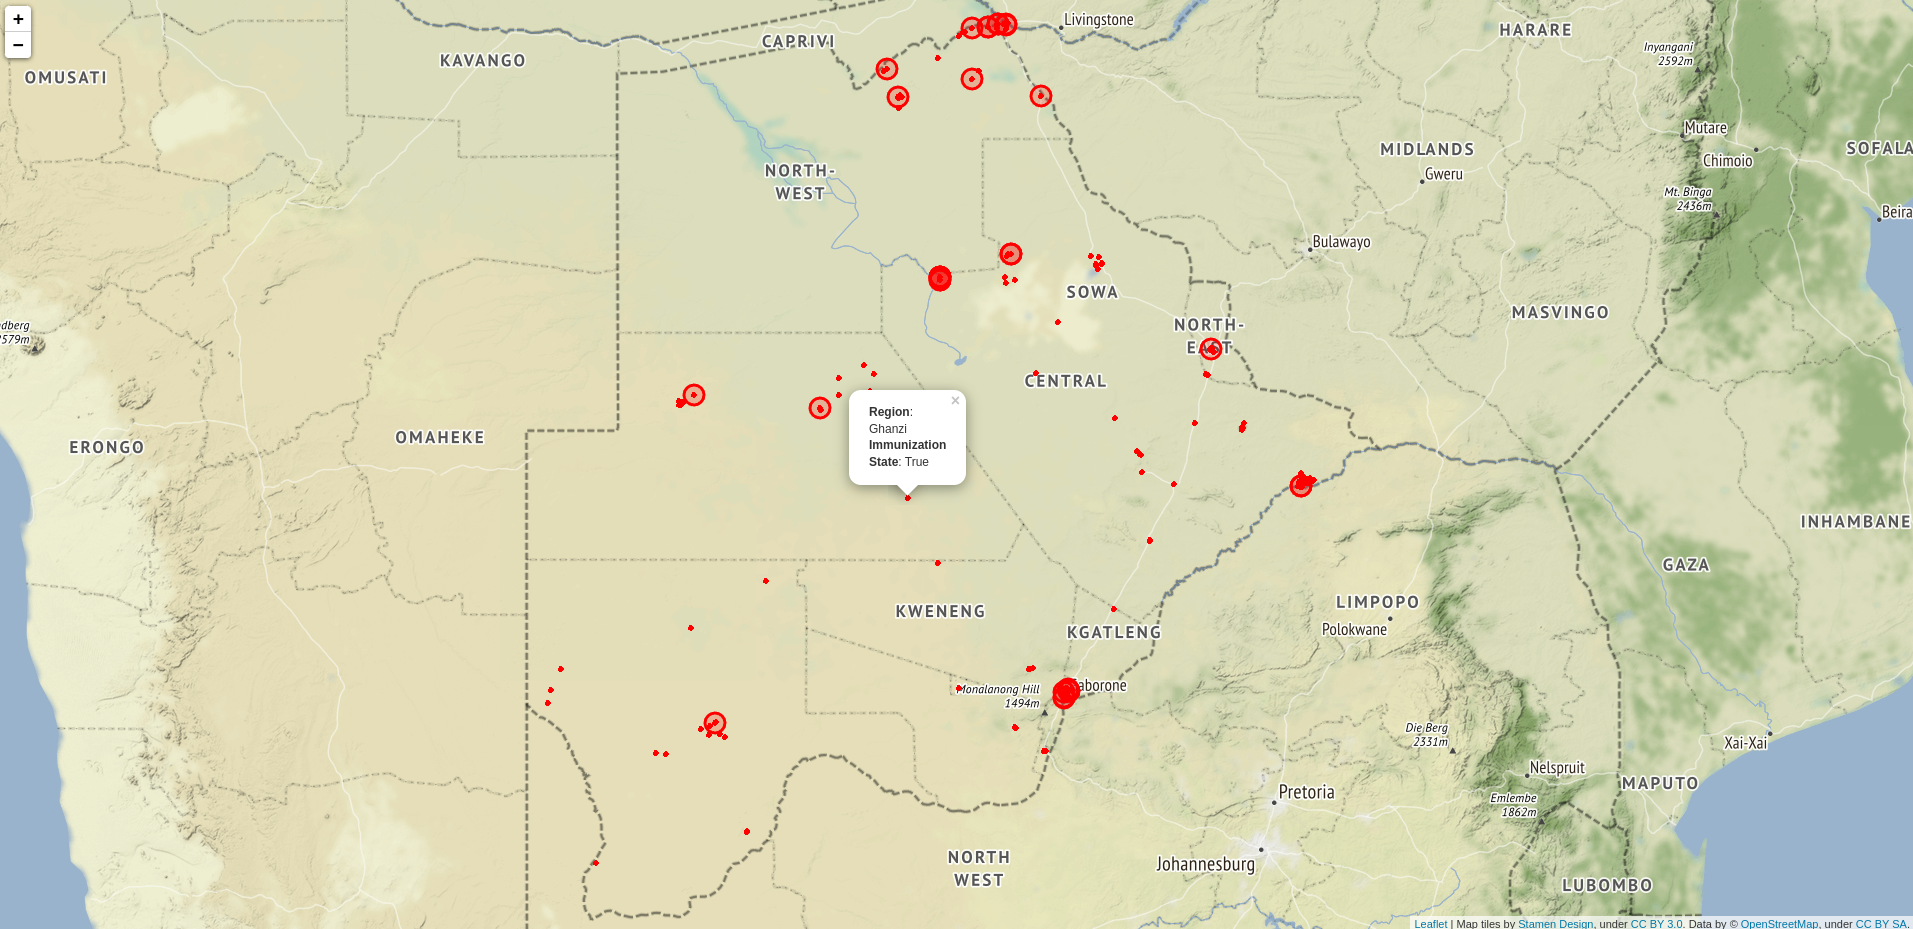

In [ ]:

Image(filename='/home/david/Elvis/macro-eyes/ML_Assignment/images/Botswana.png')


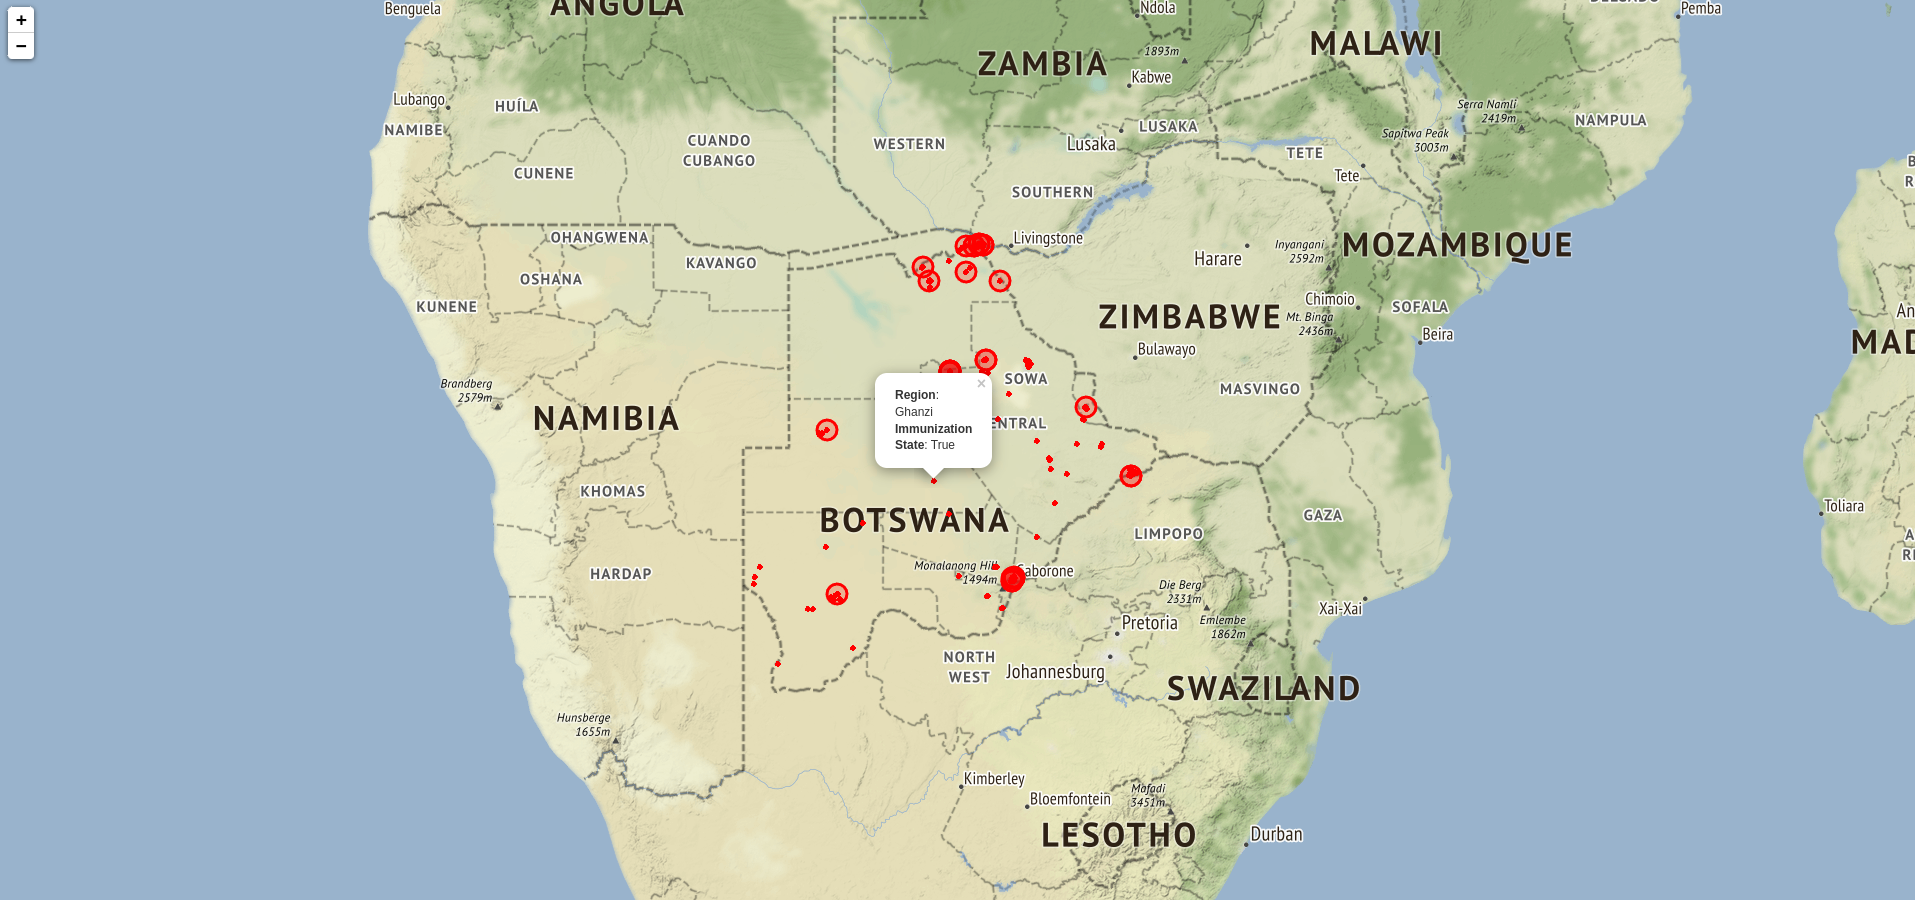

In [ ]:
Image(filename='/home/david/Elvis/macro-eyes/ML_Assignment/images/Botswa.png')


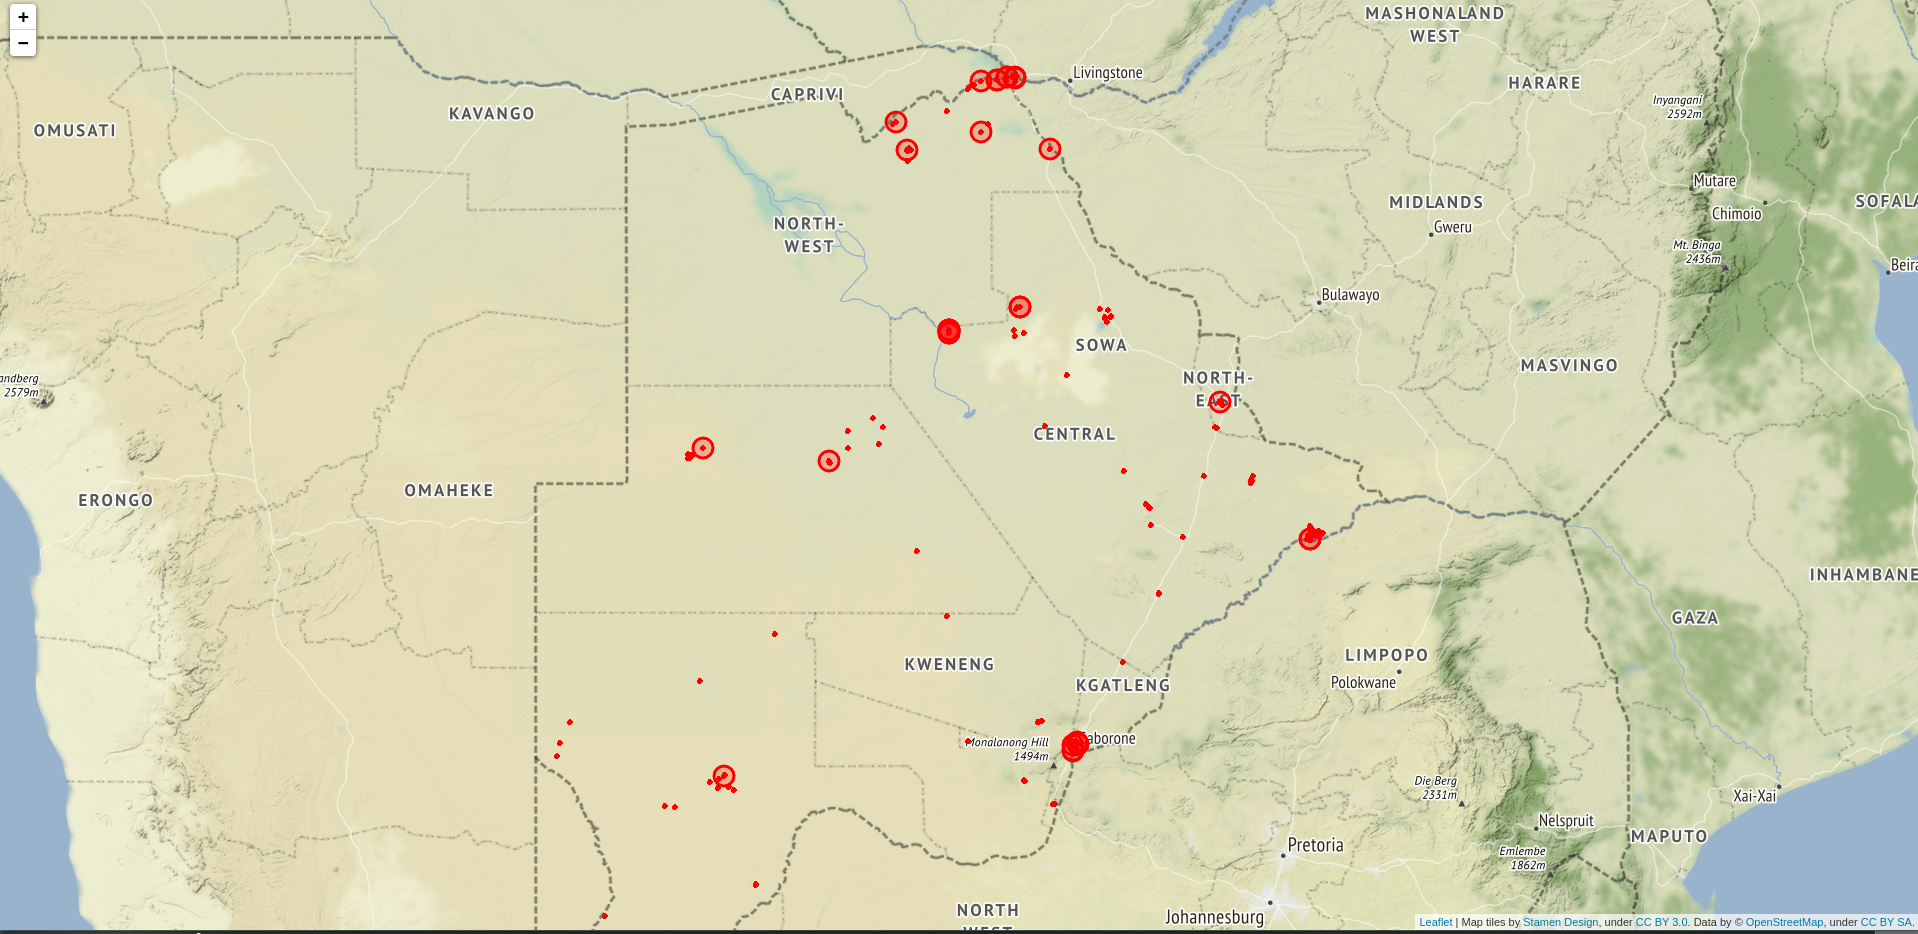

In [ ]:
Image(filename='/home/david/Elvis/macro-eyes/ML_Assignment/images/bot_map.png')


The image is from an interactive map showing the different regions in botswana and the immunization state, if there are cases of immunization drop outs, the state will be False and if there are no cases, it will be True.

## Improvement opportunity

**I Identified some axes for improvement opportunity:**

- Data augmentation using data from different data sources e.g

     - UNICEF Data warehouse, (Immunization coverage survey data, [Percentage of surviving infants who received the third dose of DTP-containing vaccine data](https://data.unicef.org/resources/data_explorer/unicef_f/?ag=UNICEF&df=GLOBAL_DATAFLOW&ver=1.0&dq=BWA.IM_DTP3.&startPeriod=1970&endPeriod=2022))

     - WHO immunization data which shows the coverage of immunization in the previous years for botswana
     
     - From Botswana Multi-year Immunization plan which is an extensive report on the previous coverage and predicted coverage of the regions

With data augmentation, we will have access to a lot of information which is important that will help our model to perform better and attain more accuracy.

### The main artifacts resulted from the project and how they will help health facilities allocate health workers

- **Visual map of botswana regions with predicted success of immunization:** 

     - With the map, the health facilities are able to identify regions where there are fewer number of facilities/workers hence magnify there focus to those areas


- **Model Predictions:**

     - Through the predictions from the model,the health facilities have access to precise and accurate information of regions and districts with drop outs and through that more workers can be deployed to the place.

     - It will also save on cost optimization of allocating health workers since with accurate information and map or coordinates, health workers from the nearest facility will be allocated.
     

- This will together improve the procurement and supply of the health products in the country at large